In [1]:
import pandas as pd
import SDSSdownload as sd

# astropy will yell about deprecated FITS stuff, as usual
import warnings
warnings.filterwarnings("ignore")

#### Using the Nair & Abraham catalog that we'll be training our bar detection model on, but any RA and Dec will work
##### Available at: http://www.bo.astro.it/~nair/Morphology/Visual_Morphology.html

In [2]:
cat = pd.read_csv("NairAbrahamMorphology.cat", delim_whitespace=True)
i = 4444
ra, dec = cat.RA[i],cat.DEC[i]
ra,dec

(183.921, 65.66)

In [3]:
# default save directories are /data/ and /images/
test_dir = './test/'

dl = sd.Image(ra,dec, image_dir=test_dir, data_dir=test_dir)

#### We can get the data in the form of a numpy array
##### image_size=n determines the size of the cutout
##### Default is n=151, but will likely want larger if looking for e.g. tidal features
###### TO DO: find a way to make the image size automatically fit to the galaxy. Some multiple of the petrosian radius converted into pixels?

In [4]:
data_array = dl.data()
data_array

array([[[-0.05267334, -0.0163269 , -0.02749634],
        [-0.05267334,  0.01425171,  0.01400757],
        [-0.00378418, -0.00614166, -0.00259399],
        ...,
        [ 0.09375   ,  0.01931763,  0.00156212],
        [-0.01782227,  0.03460693, -0.00257874],
        [-0.05267334,  0.02441406,  0.01812744]],

       [[ 0.04510498,  0.01934814, -0.01504517],
        [-0.03869629, -0.01124573, -0.02334595],
        [-0.00378036,  0.01425171, -0.01089478],
        ...,
        [ 0.03796387, -0.00618744,  0.05126953],
        [ 0.05194092,  0.0295105 , -0.01086426],
        [ 0.10766602, -0.00618744, -0.0274353 ]],

       [[ 0.07995605,  0.01425171,  0.01400757],
        [ 0.03112793,  0.00405121, -0.00674438],
        [ 0.00320435,  0.02444458,  0.02230835],
        ...,
        [ 0.00310898, -0.05718994, -0.00257874],
        [ 0.04492188,  0.01420593,  0.00984192],
        [-0.01083374, -0.01638794, -0.01499939]],

       ...,

       [[-0.06628418, -0.03186035,  0.00562286],
        [-0

#### We can plot either a cutout around the target galaxy, or the whole image downloaded from SDSS

##### First, a black and white cutout in a single filter

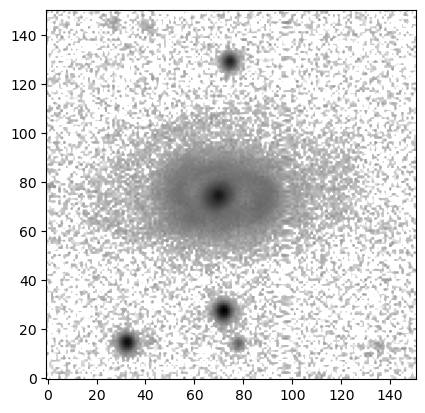

In [5]:
# plot the galaxy in a single filter ('r' is default)

dl.plot()

##### Now let's plot the entire region

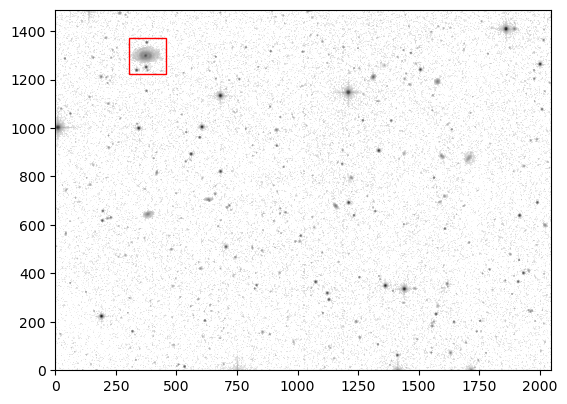

In [6]:
# box=True adds a box around the target galaxy
dl.plot_region(box=True)

#### We can also plot in color

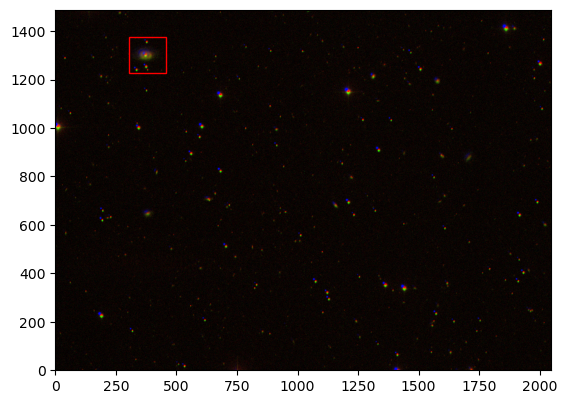

In [7]:
# We can also plot in color
dl.plot_region_color(box=True)

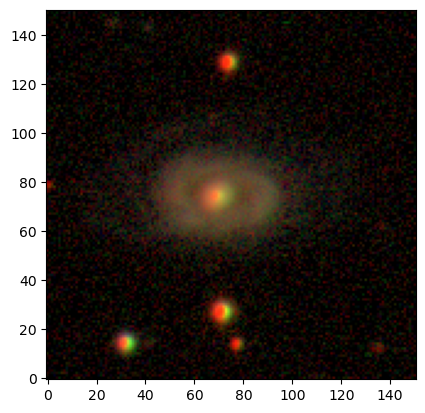

In [8]:
dl.plot_color()

#### The color plot functions can be adjusted with the parameters Q and stretch
##### See: https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html#astropy.visualization.make_lupton_rgb

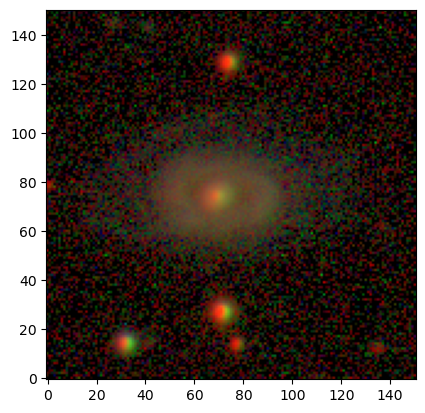

In [9]:
# defaults are Q=10 and stretch=0.5
dl.plot_color(Q=20, stretch=0.2)

#### We can save the image and the numpy array
##### Can save a single filter image with save_plot(), and the whole region with save_plot_region() or save_plot_region_color()
##### Likewise, can also save whole region data with save_data_region()
##### In either case, you can use the dir='...' argument to update the directory now.

In [10]:
# save image as a png and the data as a numpy file
dl.save_plot_color()
dl.save_data()

In [11]:
# open them up to test them
import numpy as np

data = np.load(f"./test/{dl.objid}.npy")
data

array([[[-0.05267334, -0.0163269 , -0.02749634],
        [-0.05267334,  0.01425171,  0.01400757],
        [-0.00378418, -0.00614166, -0.00259399],
        ...,
        [ 0.09375   ,  0.01931763,  0.00156212],
        [-0.01782227,  0.03460693, -0.00257874],
        [-0.05267334,  0.02441406,  0.01812744]],

       [[ 0.04510498,  0.01934814, -0.01504517],
        [-0.03869629, -0.01124573, -0.02334595],
        [-0.00378036,  0.01425171, -0.01089478],
        ...,
        [ 0.03796387, -0.00618744,  0.05126953],
        [ 0.05194092,  0.0295105 , -0.01086426],
        [ 0.10766602, -0.00618744, -0.0274353 ]],

       [[ 0.07995605,  0.01425171,  0.01400757],
        [ 0.03112793,  0.00405121, -0.00674438],
        [ 0.00320435,  0.02444458,  0.02230835],
        ...,
        [ 0.00310898, -0.05718994, -0.00257874],
        [ 0.04492188,  0.01420593,  0.00984192],
        [-0.01083374, -0.01638794, -0.01499939]],

       ...,

       [[-0.06628418, -0.03186035,  0.00562286],
        [-0

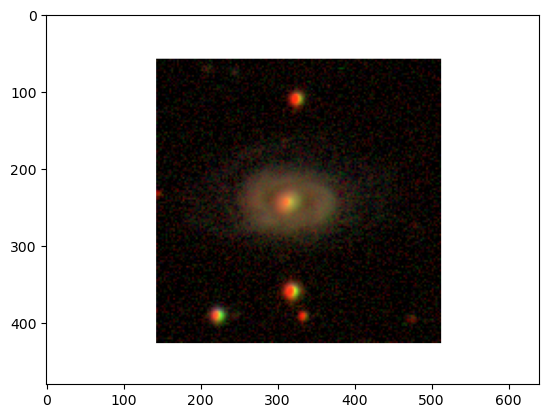

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

plt.imshow(Image.open(f"./test/{dl.objid}.png"))

#### Success! Well, sort of...
##### TO DO: get rid of the extra white space around the saved images

#### Now we can do the real work. Let's download and save a few galaxies at once.

#### NOTE: if you want to specify the image_size, do data(image_size=...) before saving images, otherwise they use the default value

In [13]:
# Let's get the same galaxy again, and the next 5 after it.
ind = [4444, 4445, 4446, 4447, 4448, 4449]
for i in ind:
    ra, dec = cat.RA[i],cat.DEC[i]
    new_dl = sd.Image(ra,dec, image_dir=test_dir, data_dir=test_dir)
    #data = new_dl.data(image_size=200)
    new_dl.save_plot_color()
    new_dl.save_data()